# Julia is fast

Very often, benchmarks are used to compare languages.  These benchmarks can lead to long discussions, first as to exactly what is being benchmarked and secondly what explains the differences.  These simple questions can sometimes get more complicated than you at first might imagine.

The purpose of this notebook is for you to see a simple benchmark for yourself.  One can read the notebook and see what happened on the author's Macbook Pro with a 4-core Intel Core I7, or run the notebook yourself.

(This material began life as a wonderful lecture by Steven Johnson at MIT: https://github.com/stevengj/18S096/blob/master/lectures/lecture1/Boxes-and-registers.ipynb.)

# Outline of this notebook

- Define the sum function
- Implementations & benchmarking of sum in...
    - C (hand-written)
    - C (hand-written with -ffast-math)
    - python (built-in)
    - python (numpy)
    - python (hand-written)
    - Julia (built-in)
    - Julia (hand-written)
    - Julia (hand-written with SIMD)
- Summary of benchmarks

# `sum`: An easy enough function to understand

Consider the  **sum** function `sum(a)`, which computes
$$
\mathrm{sum}(a) = \sum_{i=1}^n a_i,
$$
where $n$ is the length of `a`.

In [1]:
a = rand(10^7) # 1D vector of random numbers, uniform on [0,1)

10000000-element Array{Float64,1}:
 0.9429211231534997
 0.1554386173530562
 0.8996468429486966
 0.3608595679786153
 0.9723638816628661
 0.9782789993389707
 0.5493277476540923
 0.1442213035406319
 0.8357035239317694
 0.039789689941040374
 0.8093562135100871
 0.7022980525707403
 0.9751398210430033
 ⋮
 0.5096509607525583
 0.36829476507274483
 0.15365017248709334
 0.4676311813117706
 0.9702775819241662
 0.7010472005188777
 0.844392709779543
 0.4331641834885023
 0.019912511031036306
 0.7364963157496491
 0.05843324916059789
 0.7813530928979462

In [2]:
sum(a)

4.999275192106271e6

The expected result is 0.5 * 10^7, since the mean of each entry is 0.5

# Benchmarking a few ways in a few languages

In [3]:
@time sum(a)

  0.004154 seconds (1 allocation: 16 bytes)


4.999275192106271e6

In [4]:
@time sum(a)

  0.005099 seconds (1 allocation: 16 bytes)


4.999275192106271e6

In [5]:
@time sum(a)

  0.005189 seconds (1 allocation: 16 bytes)


4.999275192106271e6

The `@time` macro can yield noisy results, so it's not our best choice for benchmarking!

Luckily, Julia has a `BenchmarkTools.jl` package to make benchmarking easy and accurate:

In [6]:
using Pkg
Pkg.add("BenchmarkTools")

   Updating registry at `/opt/julia/registries/General`
######################################################################### 100.0%
  Resolving package versions...
  Installed NaNMath ───────── v0.3.4
  Installed Requires ──────── v1.1.0
  Installed Tables ────────── v1.1.0
  Installed BenchmarkTools ── v0.5.0
  Installed RecipesPipeline ─ v0.1.13
  Installed Plots ─────────── v1.7.3
  Installed GeometryTypes ─── v0.8.3
  Installed Contour ───────── v0.5.5
  Installed RecipesBase ───── v1.1.0
  Installed Latexify ──────── v0.14.3
  Installed GR ────────────── v0.52.0
Updating `/opt/julia/environments/v1.5/Project.toml`
  [6e4b80f9] + BenchmarkTools v0.5.0
  [91a5bcdd] ↓ Plots v1.9.1 ⇒ v1.7.3
Updating `/opt/julia/environments/v1.5/Manifest.toml`
  [6e4b80f9] + BenchmarkTools v0.5.0
  [83423d85] - Cairo_jll v1.16.0+6
  [d38c429a] ↓ Contour v0.5.6 ⇒ v0.5.5
  [2e619515] - Expat_jll v2.2.7+6
  [a3f928ae] - Fontconfig_jll v2.13.1+14
  [0656b61e] - GLFW_jll v3.3.2+1
  [28b8d3ca] ↓ GR v0.

In [7]:
using BenchmarkTools  

┌ Info: Precompiling BenchmarkTools [6e4b80f9-dd63-53aa-95a3-0cdb28fa8baf]
└ @ Base loading.jl:1278


#  1. The C language

C is often considered the gold standard: difficult on the human, nice for the machine. Getting within a factor of 2 of C is often satisfying. Nonetheless, even within C, there are many kinds of optimizations possible that a naive C writer may or may not get the advantage of.

The current author does not speak C, so he does not read the cell below, but is happy to know that you can put C code in a Julia session, compile it, and run it. Note that the `"""` wrap a multi-line string.

In [8]:
using Libdl
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file


# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc -fPIC -O3 -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum (generic function with 1 method)

In [9]:
c_sum(a)

4.999275192105485e6

In [10]:
c_sum(a) ≈ sum(a) # type \approx and then <TAB> to get the ≈ symbolb

true

In [11]:
c_sum(a) - sum(a)  

-7.860362529754639e-7

In [13]:
≈  # alias for the `isapprox` function

isapprox (generic function with 9 methods)

In [14]:
?isapprox

search: isapprox



```
isapprox(x, y; rtol::Real=atol>0 ? 0 : √eps, atol::Real=0, nans::Bool=false, norm::Function)
```

Inexact equality comparison: `true` if `norm(x-y) <= max(atol, rtol*max(norm(x), norm(y)))`. The default `atol` is zero and the default `rtol` depends on the types of `x` and `y`. The keyword argument `nans` determines whether or not NaN values are considered equal (defaults to false).

For real or complex floating-point values, if an `atol > 0` is not specified, `rtol` defaults to the square root of [`eps`](@ref) of the type of `x` or `y`, whichever is bigger (least precise). This corresponds to requiring equality of about half of the significand digits. Otherwise, e.g. for integer arguments or if an `atol > 0` is supplied, `rtol` defaults to zero.

`x` and `y` may also be arrays of numbers, in which case `norm` defaults to the usual `norm` function in LinearAlgebra, but may be changed by passing a `norm::Function` keyword argument. (For numbers, `norm` is the same thing as `abs`.) When `x` and `y` are arrays, if `norm(x-y)` is not finite (i.e. `±Inf` or `NaN`), the comparison falls back to checking whether all elements of `x` and `y` are approximately equal component-wise.

The binary operator `≈` is equivalent to `isapprox` with the default arguments, and `x ≉ y` is equivalent to `!isapprox(x,y)`.

Note that `x ≈ 0` (i.e., comparing to zero with the default tolerances) is equivalent to `x == 0` since the default `atol` is `0`.  In such cases, you should either supply an appropriate `atol` (or use `norm(x) ≤ atol`) or rearrange your code (e.g. use `x ≈ y` rather than `x - y ≈ 0`).   It is not possible to pick a nonzero `atol` automatically because it depends on the overall scaling (the "units") of your problem: for example, in `x - y ≈ 0`, `atol=1e-9` is an absurdly small tolerance if `x` is the [radius of the Earth](https://en.wikipedia.org/wiki/Earth_radius) in meters, but an absurdly large tolerance if `x` is the [radius of a Hydrogen atom](https://en.wikipedia.org/wiki/Bohr_radius) in meters.

# Examples

```jldoctest
julia> 0.1 ≈ (0.1 - 1e-10)
true

julia> isapprox(10, 11; atol = 2)
true

julia> isapprox([10.0^9, 1.0], [10.0^9, 2.0])
true

julia> 1e-10 ≈ 0
false

julia> isapprox(1e-10, 0, atol=1e-8)
true
```

---

```
isapprox(x; kwargs...) / ≈(x; kwargs...)
```

Create a function that compares its argument to `x` using `≈`, i.e. a function equivalent to `y -> y ≈ x`.

The keyword arguments supported here are the same as those in the 2-argument `isapprox`.


We can now benchmark the C code directly from Julia:

In [15]:
c_bench = @benchmark c_sum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     10.362 ms (0.00% GC)
  median time:      10.441 ms (0.00% GC)
  mean time:        10.509 ms (0.00% GC)
  maximum time:     11.287 ms (0.00% GC)
  --------------
  samples:          476
  evals/sample:     1

In [16]:
println("C: Fastest time was $(minimum(c_bench.times) / 1e6) msec")

C: Fastest time was 10.362172 msec


In [17]:
d = Dict()  # a "dictionary", i.e. an associative array
d["C"] = minimum(c_bench.times) / 1e6  # in milliseconds
d

Dict{Any,Any} with 1 entry:
  "C" => 10.3622

In [18]:
using Plots
gr()

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278


Plots.GRBackend()

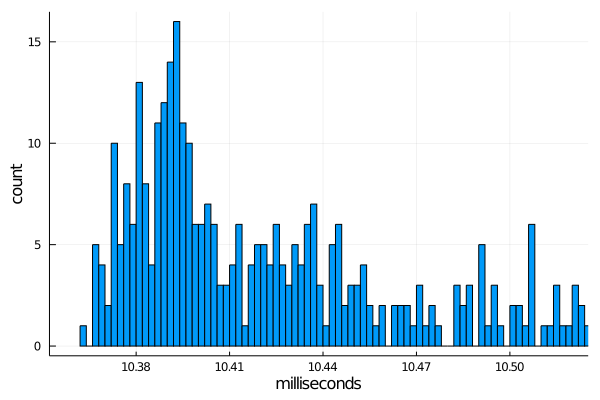

In [19]:
using Statistics # bring in statistical support for standard deviations
t = c_bench.times / 1e6 # times in milliseconds
m, σ = minimum(t), std(t)

histogram(t, bins=500,
    xlim=(m - 0.01, m + σ),
    xlabel="milliseconds", ylabel="count", label="")

# 2. C with -ffast-math

If we allow C to re-arrange the floating point operations, then it'll vectorize with SIMD (single instruction, multiple data) instructions.

In [20]:
const Clib_fastmath = tempname()   # make a temporary file

# The same as above but with a -ffast-math flag added
open(`gcc -fPIC -O3 -msse3 -xc -shared -ffast-math -o $(Clib_fastmath * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum_fastmath(X::Array{Float64}) = ccall(("c_sum", Clib_fastmath), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum_fastmath (generic function with 1 method)

In [21]:
c_fastmath_bench = @benchmark $c_sum_fastmath($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     5.651 ms (0.00% GC)
  median time:      5.712 ms (0.00% GC)
  mean time:        5.762 ms (0.00% GC)
  maximum time:     7.066 ms (0.00% GC)
  --------------
  samples:          868
  evals/sample:     1

In [22]:
d["C -ffast-math"] = minimum(c_fastmath_bench.times) / 1e6  # in milliseconds

5.650656

# 3. Python's built in `sum` 

The `PyCall` package provides a Julia interface to Python:

In [24]:
using Pkg; Pkg.add("PyCall")
using PyCall

  Resolving package versions...
  Installed PyCall ─ v1.92.1
Updating `/opt/julia/environments/v1.5/Project.toml`
  [438e738f] + PyCall v1.92.1
Updating `/opt/julia/environments/v1.5/Manifest.toml`
  [438e738f] + PyCall v1.92.1
   Building PyCall → `/opt/julia/packages/PyCall/BcTLp/deps/build.log`
┌ Info: Precompiling PyCall [438e738f-606a-5dbb-bf0a-cddfbfd45ab0]
└ @ Base loading.jl:1278


In [25]:
# get the Python built-in "sum" function:
pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [26]:
pysum(a)

4.999275192105485e6

In [27]:
pysum(a) ≈ sum(a)

true

In [28]:
py_list_bench = @benchmark $pysum($a)

BenchmarkTools.Trial: 
  memory estimate:  336 bytes
  allocs estimate:  6
  --------------
  minimum time:     1.830 s (0.00% GC)
  median time:      1.845 s (0.00% GC)
  mean time:        1.855 s (0.00% GC)
  maximum time:     1.889 s (0.00% GC)
  --------------
  samples:          3
  evals/sample:     1

In [29]:
d["Python built-in"] = minimum(py_list_bench.times) / 1e6
d

Dict{Any,Any} with 3 entries:
  "C"               => 10.3622
  "Python built-in" => 1830.35
  "C -ffast-math"   => 5.65066

# 4. Python: `numpy` 

## Takes advantage of hardware "SIMD", but only works when it works.

`numpy` is an optimized C library, callable from Python.
It may be installed within Julia as follows:

In [31]:
using Pkg; Pkg.add("Conda")
using Conda

  Resolving package versions...
Updating `/opt/julia/environments/v1.5/Project.toml`
  [8f4d0f93] + Conda v1.5.0
No Changes to `/opt/julia/environments/v1.5/Manifest.toml`


In [32]:
Conda.add("numpy")

┌ Info: Downloading miniconda installer ...
└ @ Conda /opt/julia/packages/Conda/x5ml4/src/Conda.jl:158


PREFIX=/opt/julia/conda/3


┌ Info: Installing miniconda ...
└ @ Conda /opt/julia/packages/Conda/x5ml4/src/Conda.jl:168


Unpacking payload ...


Solving environment: ...working... done

## Package Plan ##

  environment location: /opt/julia/conda/3

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - brotlipy==0.7.0=py38h27cfd23_1003
    - ca-certificates==2020.10.14=0
    - certifi==2020.6.20=pyhd3eb1b0_3
    - cffi==1.14.3=py38h261ae71_2
    - chardet==3.0.4=py38h06a4308_1003
    - conda-package-handling==1.7.2=py38h03888b9_0
    - conda==4.9.2=py38h06a4308_0
    - cryptography==3.2.1=py38h3c74f83_1
    - idna==2.10=py_0
    - ld_impl_linux-64==2.33.1=h53a641e_7
    - libedit==3.1.20191231=h14c3975_1
    - libffi==3.3=he6710b0_2
    - libgcc-ng==9.1.0=hdf63c60_0
    - libstdcxx-ng==9.1.0=hdf63c60_0
    - ncurses==6.2=he6710b0_1
    - openssl==1.1.1h=h7b6447c_0
    - pip==20.2.4=py38h06a4308_0
    - pycosat==0.6.3=py38h7b6447c_1
    - pycparser==2.20=py_2
    - pyopenssl==19.1.0=pyhd3eb1b0_1
    - pysocks==1.7.1=py38h06a4308_0
    - python==3.8.5=h7579374_1
    - readline==8.0=h7b6447c_0
    - requests==2.24.0=py_0
  

┌ Info: Running `conda config --add channels defaults --file /opt/julia/conda/3/condarc-julia.yml --force` in root environment
└ @ Conda /opt/julia/packages/Conda/x5ml4/src/Conda.jl:115
┌ Info: Running `conda update -y conda` in root environment
└ @ Conda /opt/julia/packages/Conda/x5ml4/src/Conda.jl:115


Solving environment: ...working... done

## Package Plan ##

  environment location: /opt/julia/conda/3

  added / updated specs:
    - conda


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2020.11.8          |   py38h06a4308_0         147 KB
    ------------------------------------------------------------
                                           Total:         147 KB

The following packages will be UPDATED:

  certifi            pkgs/main/noarch::certifi-2020.6.20-p~ --> pkgs/main/linux-64::certifi-2020.11.8-py38h06a4308_0



certifi-2020.11.8    | 147 KB    | #################################### | 100% 
Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


┌ Info: Running `conda install -y numpy` in root environment
└ @ Conda /opt/julia/packages/Conda/x5ml4/src/Conda.jl:115


Solving environment: ...working... done

## Package Plan ##

  environment location: /opt/julia/conda/3

  added / updated specs:
    - numpy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    blas-1.0                   |              mkl           6 KB
    intel-openmp-2020.2        |              254         786 KB
    mkl-2020.2                 |              256       138.3 MB
    mkl-service-2.3.0          |   py38he904b0f_0          62 KB
    mkl_fft-1.2.0              |   py38h23d657b_0         157 KB
    mkl_random-1.1.1           |   py38h0573a6f_0         341 KB
    numpy-1.19.2               |   py38h54aff64_0          22 KB
    numpy-base-1.19.2          |   py38hfa32c7d_0         4.2 MB
    ------------------------------------------------------------
                                           Total:       143.8 MB

The following NEW packages will be INSTALLED:

  blas        

In [33]:
numpy_sum = pyimport("numpy")["sum"]

py_numpy_bench = @benchmark $numpy_sum($a)

BenchmarkTools.Trial: 
  memory estimate:  336 bytes
  allocs estimate:  6
  --------------
  minimum time:     4.088 ms (0.00% GC)
  median time:      4.232 ms (0.00% GC)
  mean time:        4.425 ms (0.00% GC)
  maximum time:     7.797 ms (0.00% GC)
  --------------
  samples:          1130
  evals/sample:     1

In [34]:
numpy_sum(a)

4.999275192106269e6

In [35]:
numpy_sum(a) ≈ sum(a)

true

In [36]:
d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

Dict{Any,Any} with 4 entries:
  "C"               => 10.3622
  "Python numpy"    => 4.08774
  "Python built-in" => 1830.35
  "C -ffast-math"   => 5.65066

# 5. Python, hand-written 

In [37]:
py"""
def py_sum(A):
    s = 0.0
    for a in A:
        s += a
    return s
"""

sum_py = py"py_sum"

PyObject <function py_sum at 0x7fd0eac383a0>

In [38]:
py_hand = @benchmark $sum_py($a)

BenchmarkTools.Trial: 
  memory estimate:  336 bytes
  allocs estimate:  6
  --------------
  minimum time:     2.192 s (0.00% GC)
  median time:      2.249 s (0.00% GC)
  mean time:        2.254 s (0.00% GC)
  maximum time:     2.321 s (0.00% GC)
  --------------
  samples:          3
  evals/sample:     1

In [39]:
sum_py(a)

4.999275192105485e6

In [40]:
sum_py(a) ≈ sum(a)

true

In [41]:
d["Python hand-written"] = minimum(py_hand.times) / 1e6
d

Dict{Any,Any} with 5 entries:
  "C"                   => 10.3622
  "Python numpy"        => 4.08774
  "Python hand-written" => 2191.77
  "Python built-in"     => 1830.35
  "C -ffast-math"       => 5.65066

# 6. Julia (built-in) 

## Written directly in Julia, not in C!

In [42]:
@which sum(a)

sum(a::AbstractArray; dims) in Base at reducedim.jl:722

In [43]:
j_bench = @benchmark sum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     3.728 ms (0.00% GC)
  median time:      4.099 ms (0.00% GC)
  mean time:        4.192 ms (0.00% GC)
  maximum time:     8.404 ms (0.00% GC)
  --------------
  samples:          1193
  evals/sample:     1

In [44]:
d["Julia built-in"] = minimum(j_bench.times) / 1e6
d

Dict{Any,Any} with 6 entries:
  "C"                   => 10.3622
  "Python numpy"        => 4.08774
  "Python hand-written" => 2191.77
  "Python built-in"     => 1830.35
  "Julia built-in"      => 3.72825
  "C -ffast-math"       => 5.65066

# 7. Julia (hand-written) 

In [45]:
function mysum(A)   
    s = 0.0 # s = zero(eltype(a))
    for a in A
        s += a
    end
    s
end

mysum (generic function with 1 method)

In [46]:
j_bench_hand = @benchmark mysum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     10.466 ms (0.00% GC)
  median time:      10.559 ms (0.00% GC)
  mean time:        10.614 ms (0.00% GC)
  maximum time:     11.986 ms (0.00% GC)
  --------------
  samples:          471
  evals/sample:     1

In [48]:
d["Julia hand-written"] = minimum(j_bench_hand.times) / 1e6
d

Dict{Any,Any} with 7 entries:
  "C"                   => 10.3622
  "Python numpy"        => 4.08774
  "Julia hand-written"  => 10.4662
  "Python hand-written" => 2191.77
  "Python built-in"     => 1830.35
  "Julia built-in"      => 3.72825
  "C -ffast-math"       => 5.65066

# 8. Julia (hand-written w. simd) 

In [49]:
function mysum_simd(A)   
    s = 0.0 # s = zero(eltype(A))
    @simd for a in A
        s += a
    end
    s
end

mysum_simd (generic function with 1 method)

In [50]:
j_bench_hand_simd = @benchmark mysum_simd($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     3.688 ms (0.00% GC)
  median time:      3.744 ms (0.00% GC)
  mean time:        3.789 ms (0.00% GC)
  maximum time:     5.012 ms (0.00% GC)
  --------------
  samples:          1319
  evals/sample:     1

In [51]:
mysum_simd(a)

4.999275192106193e6

In [52]:
d["Julia hand-written simd"] = minimum(j_bench_hand_simd.times) / 1e6
d

Dict{Any,Any} with 8 entries:
  "Julia hand-written simd" => 3.6878
  "C"                       => 10.3622
  "Python numpy"            => 4.08774
  "Julia hand-written"      => 10.4662
  "Python hand-written"     => 2191.77
  "Python built-in"         => 1830.35
  "Julia built-in"          => 3.72825
  "C -ffast-math"           => 5.65066

# Summary

In [53]:
for (key, value) in sort(collect(d), by=last)
    println(rpad(key, 25, "."), lpad(round(value; digits=1), 6, "."))
end

Julia hand-written simd.....3.7
Julia built-in..............3.7
Python numpy................4.1
C -ffast-math...............5.7
C..........................10.4
Julia hand-written.........10.5
Python built-in..........1830.4
Python hand-written......2191.8
